In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

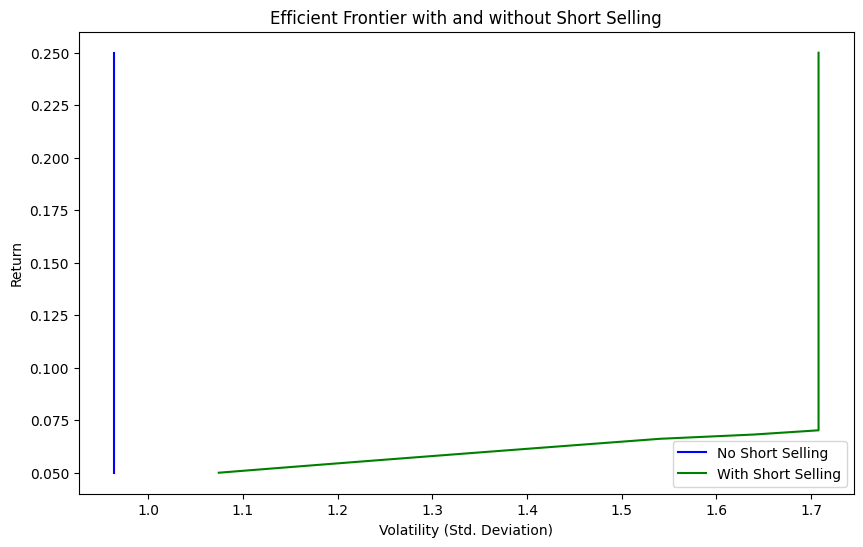

In [2]:

# Generate some random data for the assets
np.random.seed(42)
num_assets = 4
returns = np.random.randn(1000, num_assets)
mean_returns = np.mean(returns, axis=0)
cov_matrix = np.cov(returns, rowvar=False)

# Function to calculate portfolio performance (return and volatility)
def portfolio_performance(weights, mean_returns, cov_matrix):
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_volatility, portfolio_return

# Function to minimize (negative Sharpe ratio)
def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0):
    p_var, p_ret = portfolio_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

# Constraints and bounds
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds_no_short = tuple((0, 1) for asset in range(num_assets))
bounds_with_short = tuple((-1, 1) for asset in range(num_assets))

# Efficient frontier without short selling
def minimize_volatility(weights, mean_returns, cov_matrix):
    return portfolio_performance(weights, mean_returns, cov_matrix)[0]

def efficient_frontier(mean_returns, cov_matrix, bounds):
    frontier_returns = np.linspace(0.05, 0.25, 100)
    frontier_volatility = []

    for ret in frontier_returns:
        constraints = (
            {'type': 'eq', 'fun': lambda x: portfolio_performance(x, mean_returns, cov_matrix)[1] - ret},
            {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
        )
        result = minimize(minimize_volatility, num_assets * [1. / num_assets,], args=(mean_returns, cov_matrix),
                          method='SLSQP', bounds=bounds, constraints=constraints)
        frontier_volatility.append(result['fun'])

    return frontier_volatility, frontier_returns

# Calculate efficient frontiers
vol_no_short, ret_no_short = efficient_frontier(mean_returns, cov_matrix, bounds_no_short)
vol_with_short, ret_with_short = efficient_frontier(mean_returns, cov_matrix, bounds_with_short)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(vol_no_short, ret_no_short, label='No Short Selling', color='blue')
plt.plot(vol_with_short, ret_with_short, label='With Short Selling', color='green')
plt.title('Efficient Frontier with and without Short Selling')
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Return')
plt.legend()
plt.show()

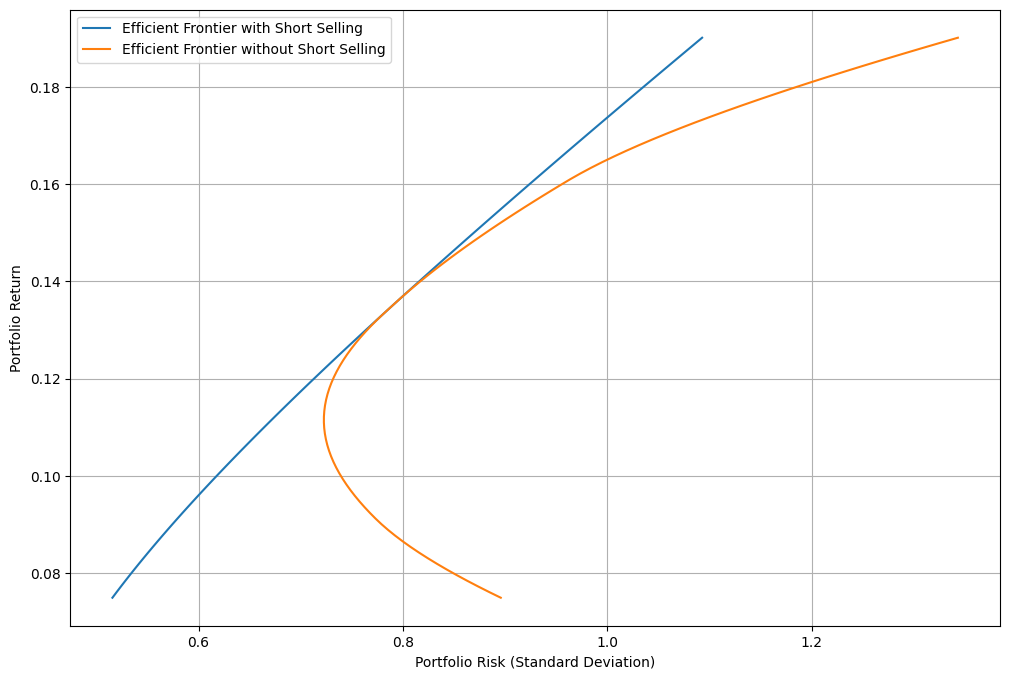

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

# Define the expected returns and covariance matrix for a set of assets
np.random.seed(42)
num_assets = 4
returns = np.random.rand(num_assets) * 0.2  # Expected returns between 0 and 0.2
cov_matrix = np.random.rand(num_assets, num_assets)
cov_matrix = np.dot(cov_matrix, cov_matrix.T)  # To make it positive semi-definite

# Generate a range of target returns
target_returns = np.linspace(min(returns), max(returns), 100)

# Lists to store portfolio risks and returns
risks_with_short = []
returns_with_short = []
risks_no_short = []
returns_no_short = []

# Loop over target returns to compute efficient frontiers
for target_return in target_returns:
    # With short selling allowed
    weights = cp.Variable(num_assets)
    portfolio_return = returns @ weights
    portfolio_variance = cp.quad_form(weights, cov_matrix)
    problem = cp.Problem(cp.Minimize(portfolio_variance),
                         [cp.sum(weights) == 1,
                          portfolio_return == target_return])
    problem.solve()
    if problem.status == cp.OPTIMAL:
        risks_with_short.append(np.sqrt(portfolio_variance.value))
        returns_with_short.append(target_return)
    
    # No short selling allowed
    weights = cp.Variable(num_assets)
    portfolio_return = returns @ weights
    portfolio_variance = cp.quad_form(weights, cov_matrix)
    problem = cp.Problem(cp.Minimize(portfolio_variance),
                         [cp.sum(weights) == 1,
                          portfolio_return == target_return,
                          weights >= 0])
    problem.solve()
    if problem.status == cp.OPTIMAL:
        risks_no_short.append(np.sqrt(portfolio_variance.value))
        returns_no_short.append(target_return)

# Plotting the efficient frontiers
plt.figure(figsize=(12, 8))
plt.plot(risks_with_short, returns_with_short, label='Efficient Frontier with Short Selling')
plt.plot(risks_no_short, returns_no_short, label='Efficient Frontier without Short Selling')
plt.xlabel('Portfolio Risk (Standard Deviation)')
plt.ylabel('Portfolio Return')
plt.legend()
plt.grid(True)
plt.show()
